In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'

from helper_functions import *

# docker start sparkbook
import pyspark as ps

spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("case study") 
        .getOrCreate()
        )

# be able to use sc as a SparkContext for compatibility 
# with pre-2.0 RDD-based spark commands
sc = spark.sparkContext

## different ways to read in the data

### look with bash

In [8]:
# bash look
!head ../data/french_tweets.json

{"created_at":"Wed Apr 26 13:30:45 +0000 2017","id":857225437122097152,"id_str":"857225437122097152","text":"Je comprends pas trop la fin de 13 reasons why \ud83d\ude13","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3137428743,"id_str":"3137428743","name":"TA\u00cfNA\u2661","screen_name":"tainabmn","location":null,"url":null,"description":null,"protected":false,"verified":false,"followers_count":318,"friends_count":406,"listed_count":2,"favourites_count":777,"statuses_count":3251,"created_at":"Sun Apr 05 16:03:00 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":"fr","contributors_enabled":false,"is_translator":false,"profile_background_color":"C0DEED","profile_background_image_url":"http:\/\/abs.twimg.com\/i

### json_list
### with open()

In [10]:
# code from case study description
import json
with open('../data/french_tweets.json', 'r', encoding = 'utf-8') as json_file:
    json_list = list(json_file)

In [5]:
json_list[0]

'{"created_at":"Wed Apr 26 13:30:45 +0000 2017","id":857225437122097152,"id_str":"857225437122097152","text":"Je comprends pas trop la fin de 13 reasons why \\ud83d\\ude13","source":"\\u003ca href=\\"http:\\/\\/twitter.com\\/download\\/iphone\\" rel=\\"nofollow\\"\\u003eTwitter for iPhone\\u003c\\/a\\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3137428743,"id_str":"3137428743","name":"TA\\u00cfNA\\u2661","screen_name":"tainabmn","location":null,"url":null,"description":null,"protected":false,"verified":false,"followers_count":318,"friends_count":406,"listed_count":2,"favourites_count":777,"statuses_count":3251,"created_at":"Sun Apr 05 16:03:00 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":"fr","contributors_enabled":false,"is_translator":false,"profile_background_color":"C0DEED","profile_background_image_url":"http:\\

### rdd_text   
### sc.textFile and making an RDD

In [6]:
rdd_text = sc.textFile('../data/french_tweets.json')

In [8]:
print("line count: {}".format(rdd_text.count()))
#line count: 216912

rdd_text.take(1)

line count: 216912


['{"created_at":"Wed Apr 26 13:30:45 +0000 2017","id":857225437122097152,"id_str":"857225437122097152","text":"Je comprends pas trop la fin de 13 reasons why \\ud83d\\ude13","source":"\\u003ca href=\\"http:\\/\\/twitter.com\\/download\\/iphone\\" rel=\\"nofollow\\"\\u003eTwitter for iPhone\\u003c\\/a\\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3137428743,"id_str":"3137428743","name":"TA\\u00cfNA\\u2661","screen_name":"tainabmn","location":null,"url":null,"description":null,"protected":false,"verified":false,"followers_count":318,"friends_count":406,"listed_count":2,"favourites_count":777,"statuses_count":3251,"created_at":"Sun Apr 05 16:03:00 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":"fr","contributors_enabled":false,"is_translator":false,"profile_background_color":"C0DEED","profile_background_image_url":"http:\

### rdd_json 
### sc.read.json and making an rdd

In [9]:
rdd_json = spark.read.json('../data/french_tweets.json').rdd

In [11]:
print("line count: {}".format(rdd_json.count())) 
#line count: 214936

rdd_json.take(1)

line count: 214936


[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 13:30:45 +0000 2017', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857225437122097152, id_str='857225437122097152', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[-0.061141, 49.208997], [-0.061141, 49.250115], [-0.032199, 49.250115], [-0.032199, 49.208997]]], type='Polygon'), country='France', country_code='FR', full_name='Dozulé, France', id='4da693e9b39923ab', name='Dozulé', place_type='city', url='https://api.twitter.com/1.1/geo/id/4da693e9b39923ab.json'), possibly_sensitive=None, quoted_status=None, quoted_status_id=None, quoted_status_id_str=None, retweet_count=0, r

### rdd_json_sample

In [12]:
### get a subset for quicker results (about 21)
rdd_json_sample = rdd_json.sample(withReplacement=False, fraction = .0001, seed=1111)
rdd_json_sample.take(1)

[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 15:02:43 +0000 2017', display_text_range=None, entities=Row(hashtags=[], media=None, symbols=[], urls=[], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857248580746268672, id_str='857248580746268672', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=False, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[2.222483, 48.868715], [2.222483, 48.895621], [2.254406, 48.895621], [2.254406, 48.868715]]], type='Polygon'), country='France', country_code='FR', full_name='Puteaux, France', id='17bb3331bbfe39dc', name='Puteaux', place_type='city', url='https://api.twitter.com/1.1/geo/id/17bb3331bbfe39dc.json'), possibly_sensitive=None, quoted_status=None, quoted_status_id=None, quoted_status_id_str=None, retweet_count=0, ret

### rdd_text_sample 

In [13]:
### get a subset for quicker results (about 21)
rdd_text_sample = rdd_text.sample(withReplacement=False, fraction = .0001, seed=1111)
rdd_text_sample.take(1)

['{"created_at":"Wed Apr 26 15:02:43 +0000 2017","id":857248580746268672,"id_str":"857248580746268672","text":"J\'ai pas eu un seul coeur de la journ\\u00e9e","source":"\\u003ca href=\\"http:\\/\\/twitter.com\\/download\\/iphone\\" rel=\\"nofollow\\"\\u003eTwitter for iPhone\\u003c\\/a\\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1949132880,"id_str":"1949132880","name":"sushi triste","screen_name":"paaraadise__","location":"478km du bonheur","url":null,"description":"i see my future in your eyes","protected":false,"verified":false,"followers_count":1389,"friends_count":871,"listed_count":8,"favourites_count":2432,"statuses_count":29753,"created_at":"Wed Oct 09 12:27:06 +0000 2013","utc_offset":7200,"time_zone":"Amsterdam","geo_enabled":true,"lang":"fr","contributors_enabled":false,"is_translator":false,"profile_background_color":"C0DEED","prof

### df_json
### sc.read.json and making a Spark dataframe

In [2]:
df_json = spark.read.json('../data/french_tweets.json')
df_json.printSchema()
# df_json.show(2) # too many columns to be helpful
print("line count: {}".format(df_json.count())) 
#line count: 214936 < 216912 reported by rdd (data loss)

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

### df_json_sample

In [3]:
### get a subset for quicker results (about 21)
df_json_sample = df_json.sample(withReplacement=False, fraction = .0001, seed=1111)
df_json_sample.take(1)

[Row(contributors=None, coordinates=None, created_at='Wed Apr 26 13:35:35 +0000 2017', display_text_range=[0, 35], entities=Row(hashtags=[], media=None, symbols=[], urls=[Row(display_url='twitter.com/quent1_derosa/…', expanded_url='https://twitter.com/quent1_derosa/status/857224833247137792', indices=[36, 59], url='https://t.co/W8OW7nkiua')], user_mentions=[]), extended_entities=None, extended_tweet=None, favorite_count=0, favorited=False, filter_level='low', geo=None, id=857226652564299778, id_str='857226652564299778', in_reply_to_screen_name=None, in_reply_to_status_id=None, in_reply_to_status_id_str=None, in_reply_to_user_id=None, in_reply_to_user_id_str=None, is_quote_status=True, lang='fr', limit=None, place=Row(bounding_box=Row(coordinates=[[[5.008686, 45.965785], [5.008686, 46.034647], [5.080827, 46.034647], [5.080827, 45.965785]]], type='Polygon'), country='France', country_code='FR', full_name='Villars-les-Dombes, France', id='008c4b306799a37a', name='Villars-les-Dombes', plac

In [4]:
# create a temporary table for spark.sql queries
df_json.createOrReplaceTempView('temp1')

In [5]:
# possibly sensitive results for all quoted_status
spark.sql(
'''
SELECT quoted_status.possibly_sensitive,
       COUNT(quoted_status.retweeted) AS count, 
       AVG(quoted_status.retweet_count) AS avg_n_retweets,
       stddev_samp(quoted_status.retweet_count) AS sd_n_retweets,
       max(quoted_status.retweet_count) AS max_n_retweets,
       MIN(quoted_status.retweet_count) AS min_n_retweets
FROM temp1
GROUP BY quoted_status.possibly_sensitive; 
'''
).show()

+------------------+-----+------------------+-----------------+--------------+--------------+
|possibly_sensitive|count|    avg_n_retweets|    sd_n_retweets|max_n_retweets|min_n_retweets|
+------------------+-----+------------------+-----------------+--------------+--------------+
|              null|10875|205.85728735632185|1289.193509294055|         45480|             0|
|              true|  512|    3036.845703125|7845.550715218757|         58847|             0|
|             false|14582|1278.4751748731312|5909.084277615833|        339281|             0|
+------------------+-----+------------------+-----------------+--------------+--------------+



In [6]:
# make samples for difference of means test
s1 = spark.sql(
'''
SELECT quoted_status.retweet_count
FROM temp1
WHERE quoted_status.possibly_sensitive=True;
'''
).collect()

s2 = spark.sql(
'''
SELECT quoted_status.retweet_count
FROM temp1
WHERE quoted_status.possibly_sensitive=False;
'''
).collect()

In [7]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [8]:
# create subsamples from query results
T = [row[0] for row in s1]
F = [row[0] for row in s2]
F_sample = random.sample(F, k=len(T)) 
    
from helper_functions import HypTest   
ht = HypTest([T, F, F_sample], ['True', 'False', 'False_Sample'], alternative='greater')

ht.descriptive_stats_df().to_markdown()

'|                   |         True |         False |   False_Sample |\n|:------------------|-------------:|--------------:|---------------:|\n| size              |   512        |  14582        |     512        |\n| mean              |  3036.85     |   1278.48     |    1090.83     |\n| sd                |  7837.89     |   5908.88     |    4334.11     |\n| min               |  3036.85     |   1278.48     |    1090.83     |\n| 1Q                |    28.75     |      3        |       2        |\n| median            |   377.5      |     34        |      31.5      |\n| 3Q                |  2493.5      |    363        |     313.75     |\n| max               | 58847        | 339281        |   65275        |\n| min_mode          |     0        |      0        |       0        |\n| 95% quantile low  |     0        |      0        |       0        |\n| 95% quantile high | 38451.1      |  11970        |    9211.57     |\n| IQR               |  2464.75     |    360        |     311.75     |\n| 1Q 

In [9]:
ht.inferential_stats_df().to_markdown()

'|             |     True |      False |   False_Sample |\n|:------------|---------:|-----------:|---------------:|\n| size        |  512     | 14582      |        512     |\n| mean        | 3036.85  |  1278.48   |       1090.83  |\n| se          |  346.389 |    48.9324 |        191.542 |\n| 95% CI low  | 2467.09  |  1197.99   |        775.773 |\n| 95% CI high | 3606.6   |  1358.96   |       1405.89  |'

In [10]:
print(f"pval = {ht.p_value()}")

pval = 3.503463501500644e-07


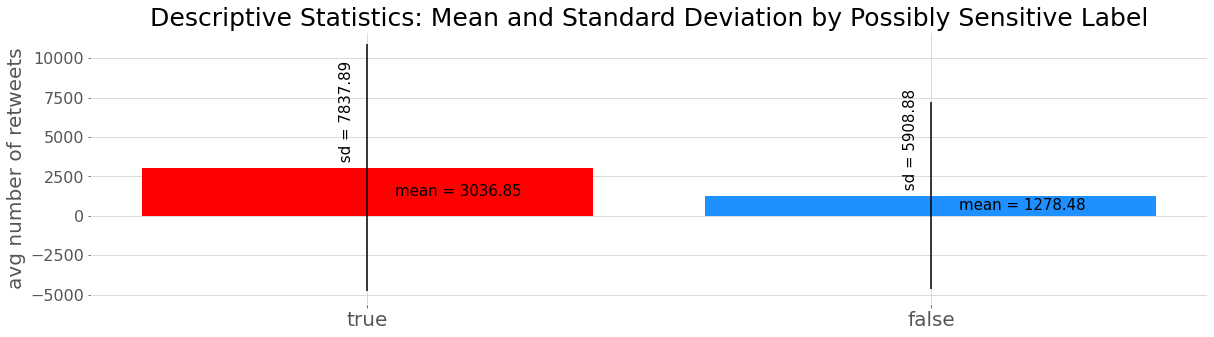

In [11]:
fig, ax = plt.subplots(figsize = (20,5))
ht.plot_mean_sd(ax)
fig.savefig('../images/barchart_means.png')

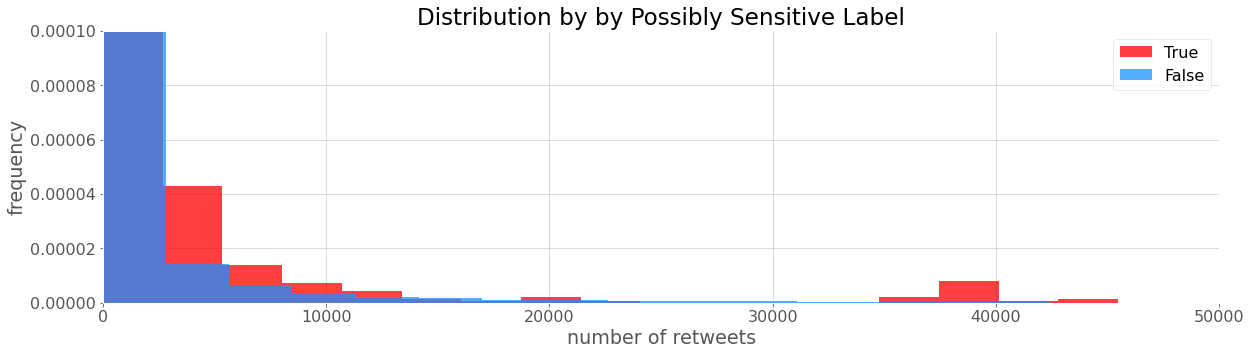

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
ht.plot_hists(ax)
ax.set_ylim(0,.00010)
ax.set_xlim(0,50000);
fig.savefig('../images/hists.png')

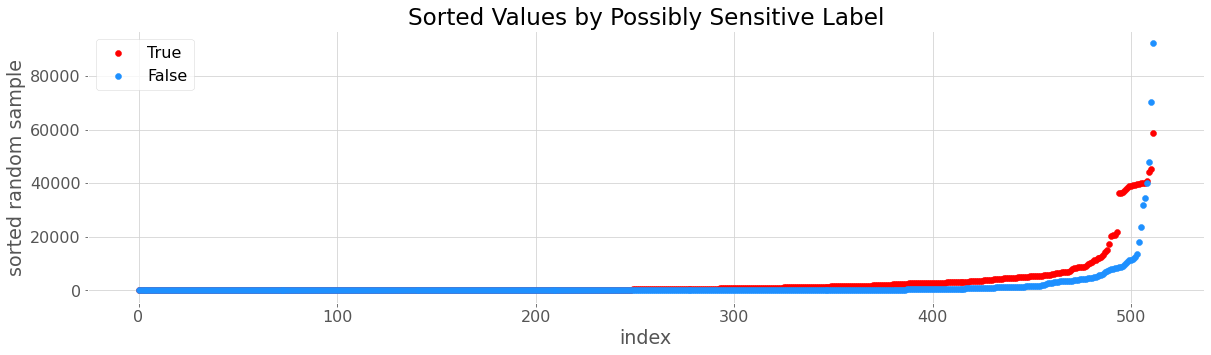

In [13]:
fig, ax = plt.subplots(figsize=(20,5))
ht.plot_sorted(ax)
fig.savefig('../images/sorted.png')

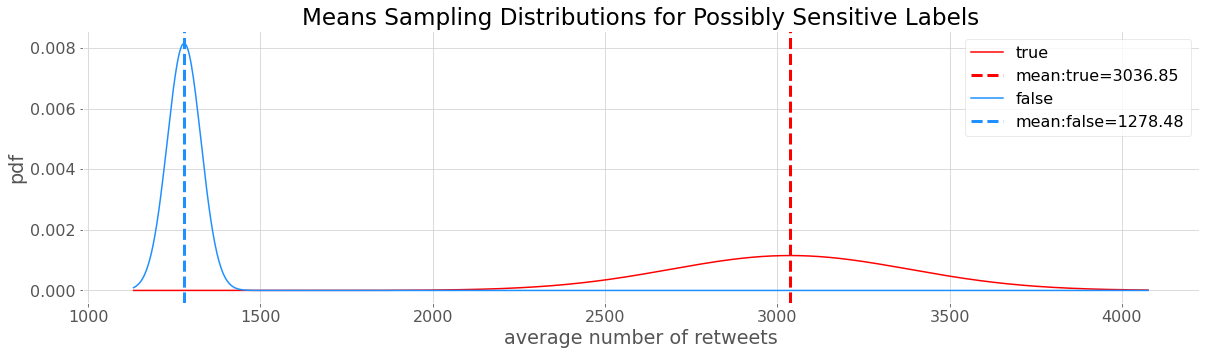

In [14]:
fig, ax = plt.subplots(figsize=(20,5))
ht.plot_sampling_distributions(ax)
fig.savefig('../images/sampling_dist.png')

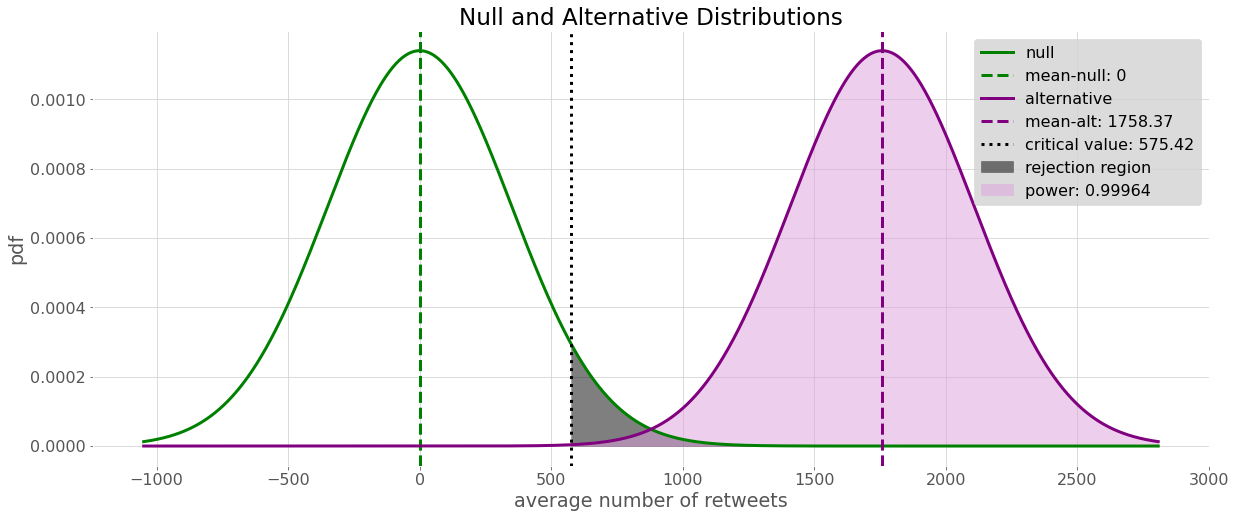

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
ht.plot_diff_of_means(ax)
fig.savefig('../images/diff_means.png')

In [16]:
ht.effect_cohens_d, ht.effect_glass_delta, ht.effect_hedges_g

(0.2533410437225854, 5.026385930471397, 0.29382694357870026)

In [17]:
ht.p_value(), ht.p_value_by_hand(), ht.pval_2sided/2

(3.503463501500644e-07, 2.499047762061224e-07, 2.499047762061224e-07)

In [18]:
### text for word clouds
 
true_text = spark.sql(
'''
SELECT quoted_status.text
FROM temp1
WHERE quoted_status.retweet_count > 0
AND quoted_status.possibly_sensitive = True; 
'''
).collect()

false_text = spark.sql(
'''
SELECT quoted_status.text
FROM temp1
WHERE quoted_status.retweet_count > 0
AND quoted_status.possibly_sensitive = False; 
'''
).collect()

In [19]:
def clean_tweet(row):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    return ''.join([char for i, char in enumerate(' '.join(row[0].split()[:-2])) if char not in punctuations])

In [20]:
cleaned_true = []
for row in texts:
    cleaned_true.append(clean_tweet(row))
wc_true = ','.join(cleaned_true)

cleaned_false = []
for row in texts:
    cleaned_false.append(clean_tweet(row))
wc_false = ','.join(cleaned_false)

NameError: name 'texts' is not defined

In [ ]:
import nltk
from nltk.corpus import stopwords
fr_stop = ['au', 'aux', 'avec', 'ca' 'ce', 'ces', 'cest', 'dans', 'de', 'des', 
           'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 
           'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 
           'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 
           'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 
           'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 
           'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 
           'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 
           'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 
           'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 
           'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 
           'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 
           'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 
           'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 
           'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 
           'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 
           'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 
           'aurez', 'auront', 'aurais', 'aurait', 'aurions', 'auriez', 
           'auraient', 'avais', 'avait', 'avions', 'aviez', 'avaient', 
           'eut', 'eûmes', 'eûtes', 'eurent', 'aie', 'aies', 'ait', 
           'ayons', 'ayez', 'aient', 'eusse', 'eusses', 'eût', 'eussions',
           'eussiez', 'eussent','i', 'me', 'my', 'myself', 'we', 'our', 
           'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
           "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 
           'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', 
           "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
           'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
           "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 
           'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 
           'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 
           'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
           'with', 'about', 'against', 'between', 'into', 'through', 'during',
           'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 
           'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
           'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 
           'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
           'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 
           't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now',
           'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', 
           "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 
           'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', 
           "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 
           'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won',
           "won't", 'wouldn', "wouldn't", 'si']

In [ ]:
stops = ['tres', 'fait', 'bien', 'dit', 'plu', 'tout', 'trop', 'comme', 'ce', 'faire', 'plus', 'nest']
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
wordcloud = WordCloud(stopwords=fr_stop+stops, 
                      width=800, 
                      height=400, 
                      min_word_length=3,
                      max_words=100).generate(wc_true)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('images/true_cloud.png')
plt.show()


In [ ]:
wordcloud = WordCloud(stopwords=fr_stop+stops, 
                      width=800, 
                      height=400, 
                      min_word_length=3,
                      max_words=100).generate(wc_false)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('images/false_cloud.png')
plt.show()

In [262]:
# # !pip install googletrans
from googletrans import Translator
translator = Translator()
translations = translator.translate(true_text)